In [86]:
import h5py
from warnings import warn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import netCDF4 as nc
from datetime import datetime as dt

import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import xarray as xr
from statsmodels.tsa.stattools import adfuller

# Introduction

This notebook contains some analysis and exlporation of the data used for both the classification and confrontation. The data used here is not the "raw data", i.e. as downloaded from the source, but it has gone through some other cleaning and processing. 

# Loading data

## Real data

In [2]:
# load the "real", i.e. satellite recorded, data
real_data = h5py.File("./data.nosync/georeferenced_wind_extremewearge_2005.h5", 'r')
# this data contains:
# (data) the 3 variables of interest (U850, UBOT, V850) (see https://extremeweatherdataset.github.io)
# (boxes) contains information as to where the cyclon is
# (latitude)
# (longitude)
# (time) saved as int8, contains the hour, day, month and year of the data

Since using all of the variables would be too expensive, and since most of the interest lies on the **U850** variables, only this shall be selected. This allows to keep at a minimum the amount of RAM used.
This data shall be saved in a ```numpy``` array, which is fairly easy to treat. The time, latitude and longitude shall be kept in the h5df file, since there is no need to move them to new variables.

In [3]:
real_data_U850 = real_data['data'][:,0,:,:]

print("Data shape:", real_data_U850.shape)
# the orded of dimensions is as follow: (time, lat, lon)

Data shape: (1456, 768, 1152)


In [4]:
# load time and change from int to numpy datetime64
real_time = real_data['time'][()].astype("<M8[us]")

## Fake data

In [5]:
# load the model generated data
print("Load fake data")
datapath = './data.nosync/b.e11.B20TRC5CNBDRD.f09_g16.002.cam.h1.U850.19200101-20051231.nc'
dataset = nc.Dataset(datapath)

fake_data = dataset['U850'][(dataset['date'][:] > 20041231)
                                       & (dataset['date'][:] < 20060101)]
fake_dates = dataset['date'][(dataset['date'][:] > 20041231)
                                       & (dataset['date'][:] < 20060101)]
# dimensions: (time, lat, lon)
lon_model = dataset['lon'][:]
lat_model = dataset['lat'][:]


Load fake data


In [6]:
# prepare the dates in the datetime64 format, in order
# to have consistency
fake_dates = (np.array(
    list(map(lambda x: dt.strptime(x, "%Y%m%d"),
             fake_dates.astype(str)))).astype("datetime64[D]"))

# Visualizations

## Single-data visualizations

### Real data

First off, let's visualize one data element. This can be handy in order to figure out what we are dealing with.

The first plot shall be the U850 just for the first day of the year.

#### Single-date

In [6]:
# select one date
first_day = real_time[0]

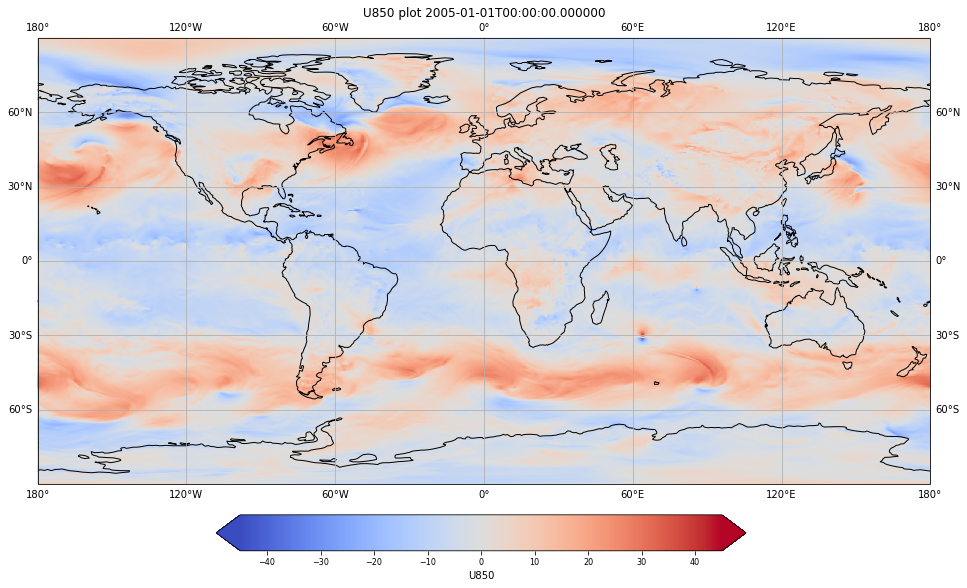

In [7]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(16, 10))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("U850 plot "+str(first_day))
ax.set_global()
mm = ax.pcolormesh(real_data['longitude'][()],
                   real_data['latitude'][()],
                   real_data_U850[np.where(real_time == first_day)[0][0],:,:],
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.coolwarm, vmin = -45, vmax = 45)

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850 [m/s]')
cbar.ax.tick_params(labelsize=8)
plt.savefig('./images/sample_real.png', dpi = 300)
plt.show()
plt.close()

The following script, which I suggest not to run, creates a gif from all of the maps over time, but just for the first 2 months (since it was too long to evaluate for all). I shall display here this aforementioned gif.
![SegmentLocal](images/wind_movie.gif "segment")

In [ ]:
for j, tt in progressbar.progressbar(
        enumerate(h5f['time'][()].astype("<M8[us]"))):
    if j < 500:
        fig = plt.figure(figsize=(23 / 2, 11 / 2))  # x,y(inches)

        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_title("U850 plot, time" + str(tt))
        ax.set_global()
        mm = ax.pcolormesh(h5f['longitude'],
                           h5f['latitude'],
                           h5f['data'][j, 0, :, :],
                           transform=ccrs.PlateCarree(),
                           cmap=mpl.cm.coolwarm,
                           vmin=-50,
                           vmax=50)

        ax.coastlines()
        ax.gridlines(draw_labels=True)

        #- add colorbar
        cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                                0.05])  #[left, bottom, width, height]
        cbar = fig.colorbar(mm,
                            cax=cbar_ax,
                            extend='both',
                            orientation='horizontal')
        cbar.set_label('U850')
        cbar.ax.tick_params(labelsize=8)
        plt.savefig('./images/U850_' + str(tt) + ".jpg")
        plt.close()
    else:
        break
        #     plt.show()
print("Creating GIF.")
images = [imageio.imread(filename) for filename in glob("./images/*.jpg")]
imageio.mimsave('./images/wind_movie.gif', images)

#### Temporal-aggregation

Givne the plot as above (see GIF), the next plot I present is a time-aggregation. That is, the average U850 wind for all coordinates in the given year (2005).

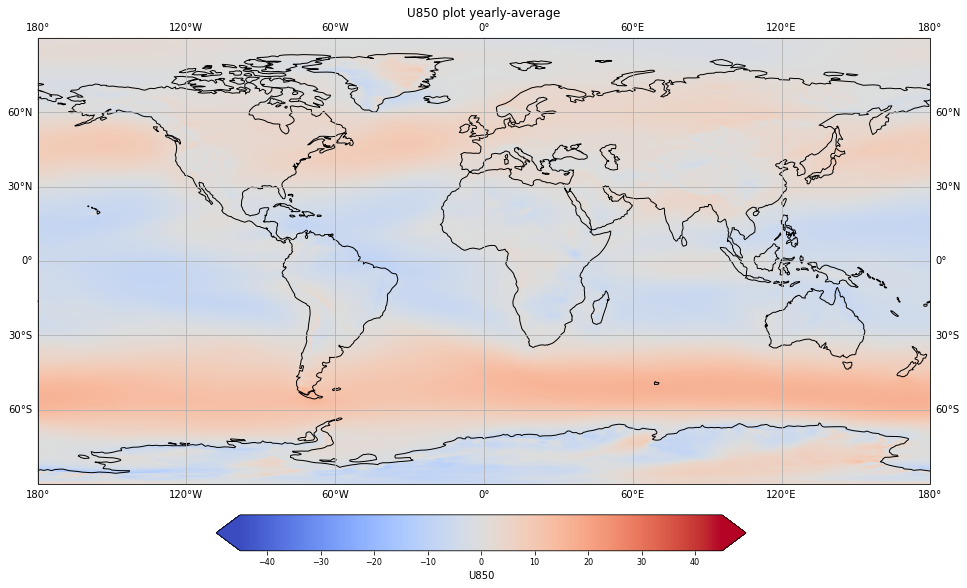

In [8]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(16, 10))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("U850 plot yearly-average")
ax.set_global()
mm = ax.pcolormesh(real_data['longitude'][()],
                   real_data['latitude'][()],
                   np.mean(real_data_U850, axis=0)[()],
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.coolwarm,
                   vmin=-45,
                   vmax=45)

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850 [m/s]')
cbar.ax.tick_params(labelsize=8)
plt.savefig("./images/average_real.png", dpi=300)
plt.show()
plt.close()

#### Space-aggregation

In this Section, I present a **time-series** of the U850 time series for the whole world. More specifically, at each time step a spatial average is performed, and then it is plotted. The objective is to see if there are times of the year where the average wind on earth increases significantly.

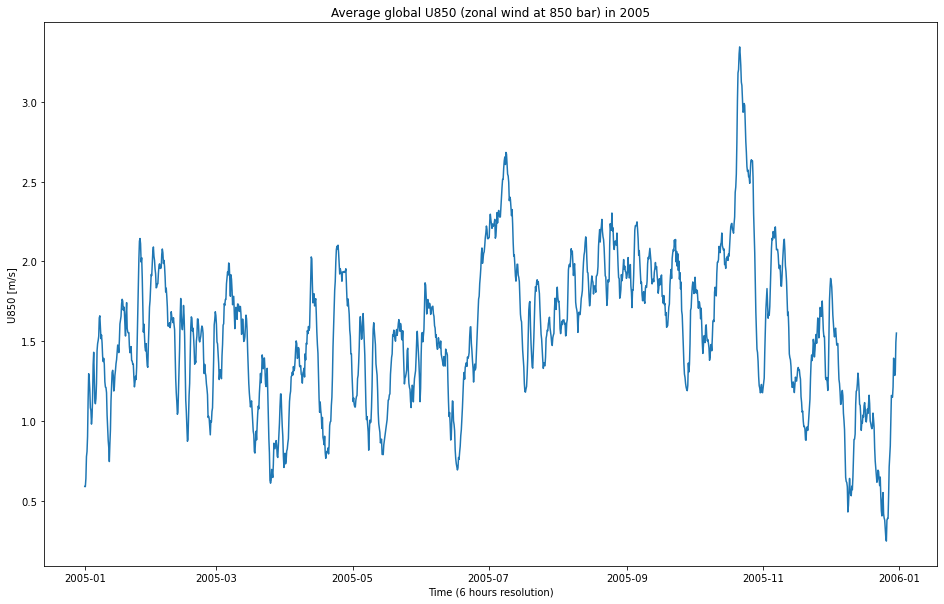

In [9]:
plt.figure(figsize = (16,10))
plt.plot(real_time, np.mean(real_data_U850, axis = (1,2)))
plt.title("Average global U850 (zonal wind at 850 bar) in 2005")
plt.xlabel("Time (6 hours resolution)")
plt.ylabel("U850 [m/s]")
plt.savefig("./images/time_series_real.pdf")
plt.show()

There are some exceptional spikes in the average. Let's see if they are connected to some well-known category-5 cylcons, of which 2005 experienced 5.

In [10]:
katrina_dates = np.arange("2005-08-23","2005-08-31",dtype='datetime64[D]')
emily_dates = np.arange("2005-07-11","2005-07-21",dtype='datetime64[D]')
rita_dates = np.arange("2005-09-18","2005-09-26",dtype='datetime64[D]')
wilma_dates = np.arange("2005-10-15","2005-10-27",dtype='datetime64[D]')

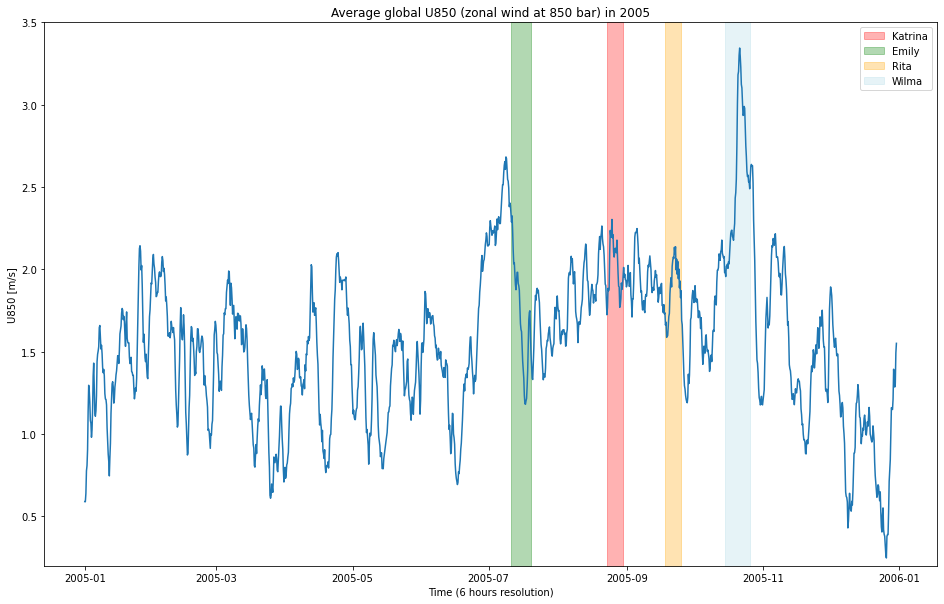

In [11]:
plt.figure(figsize = (16,10))
plt.plot(real_time, np.mean(real_data_U850, axis = (1,2)))
plt.fill_between(x = katrina_dates, y1 = 3.5, y2 = 0, color = 'red', alpha = 0.3, label = 'Katrina')
plt.fill_between(x = emily_dates, y1 = 3.5, y2 = 0, color = 'green', alpha = 0.3, label = 'Emily')
plt.fill_between(x = rita_dates, y1 = 3.5, y2 = 0, color = 'orange', alpha = 0.3, label = 'Rita')
plt.fill_between(x = wilma_dates, y1 = 3.5, y2 = 0, color = 'lightblue', alpha = 0.3, label = 'Wilma')
plt.ylim(0.2, 3.5)
plt.title("Average global U850 (zonal wind at 850 bar) in 2005")
plt.xlabel("Time (6 hours resolution)")
plt.ylabel("U850 [m/s]")
plt.legend()
plt.show()

While the visualization is nice, there seems to be not a visual strong correlation between the presence of a category-5 hurricane in the Atlantic and the augmentation of the global wind speed. There are obviously some small pikes for almost all, but nothing huge.
The only one that appears to have some effect is Wilma, but further investigation may be needed.

### Fake data

Here, the same analysis as for the real data is performed on the model generated one.

#### Single-date

In [60]:
# select one date
first_day = fake_dates[0]

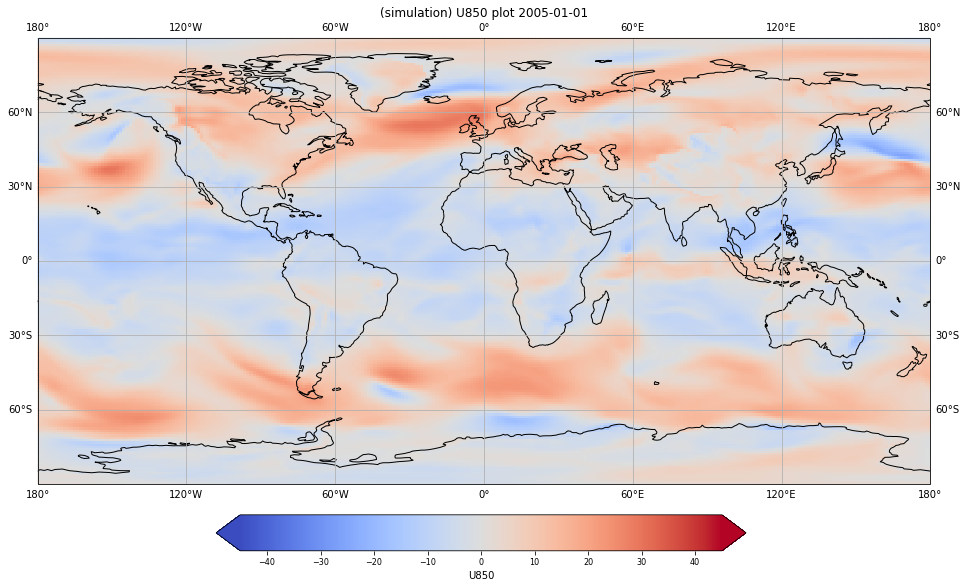

In [62]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(16, 10))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("(simulation) U850 plot "+str(first_day))
ax.set_global()
mm = ax.pcolormesh(lon_model,
                   lat_model,
                   fake_data[np.where(fake_dates == first_day)[0][0],:,:],
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.coolwarm, vmin = -45, vmax = 45)

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850')
cbar.ax.tick_params(labelsize=8)
plt.savefig('./images/sample_fake.png', dpi = 300)
plt.show()
plt.close()

#### Temporal-aggregation

Givne the plot as above (see GIF), the next plot I present is a time-aggregation. That is, the average U850 wind for all coordinates in the given year (2005).

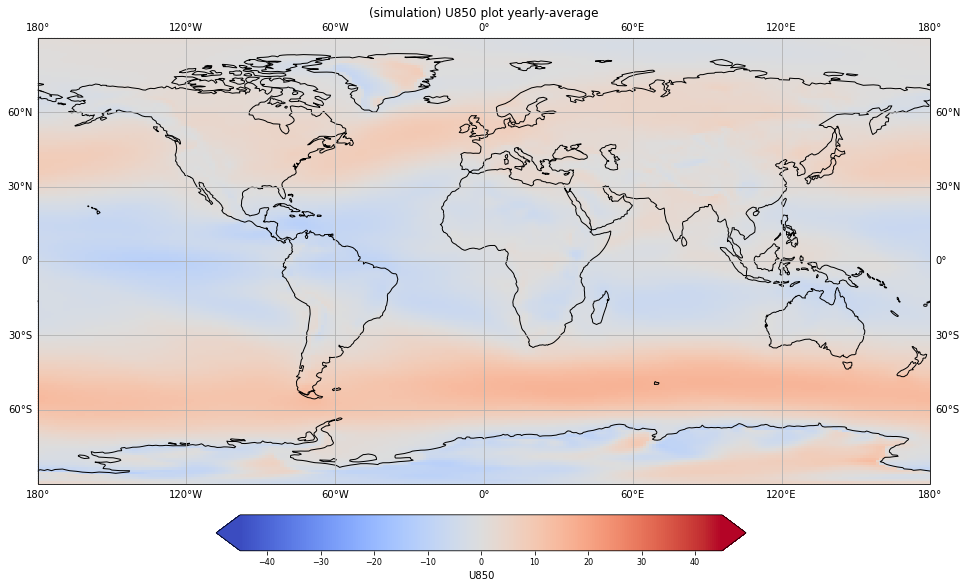

In [63]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(16, 10))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("(simulation) U850 plot yearly-average")
ax.set_global()
mm = ax.pcolormesh(lon_model,
                   lat_model,
                   np.mean(fake_data, axis=0)[()],
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.coolwarm,
                   vmin=-45,
                   vmax=45)

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850')
cbar.ax.tick_params(labelsize=8)
plt.savefig("./images/average_fake.png", dpi=300)
plt.show()
plt.close()

#### Space-aggregation

In this Section, I present a **time-series** of the U850 time series for the whole world. More specifically, at each time step a spatial average is performed, and then it is plotted. The objective is to see if there are times of the year where the average wind on earth increases significantly.

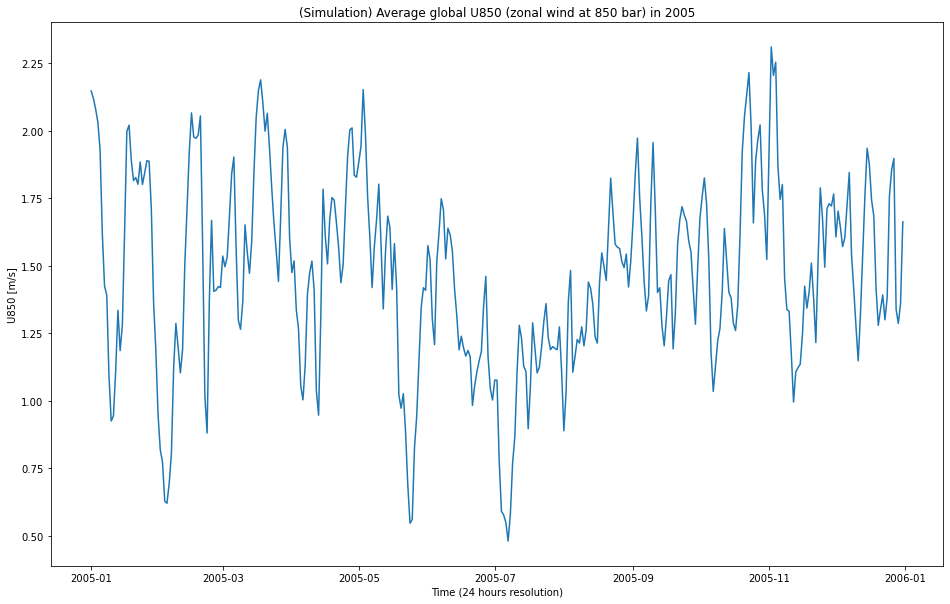

In [87]:
plt.figure(figsize = (16,10))
plt.plot(fake_dates, (np.mean(fake_data, axis = (1,2))))
plt.title("(Simulation) Average global U850 (zonal wind at 850 bar) in 2005")
plt.xlabel("Time (24 hours resolution)")
plt.ylabel("U850 [m/s]")
plt.savefig("./images/time_series_fake.pdf")
plt.show()

There are some exceptional spikes in the average. Let's see if they are connected to some well-known category-5 cylcons, of which 2005 experienced 5.

In [26]:
katrina_dates = np.arange("2005-08-23","2005-08-31",dtype='datetime64[D]')
emily_dates = np.arange("2005-07-11","2005-07-21",dtype='datetime64[D]')
rita_dates = np.arange("2005-09-18","2005-09-26",dtype='datetime64[D]')
wilma_dates = np.arange("2005-10-15","2005-10-27",dtype='datetime64[D]')

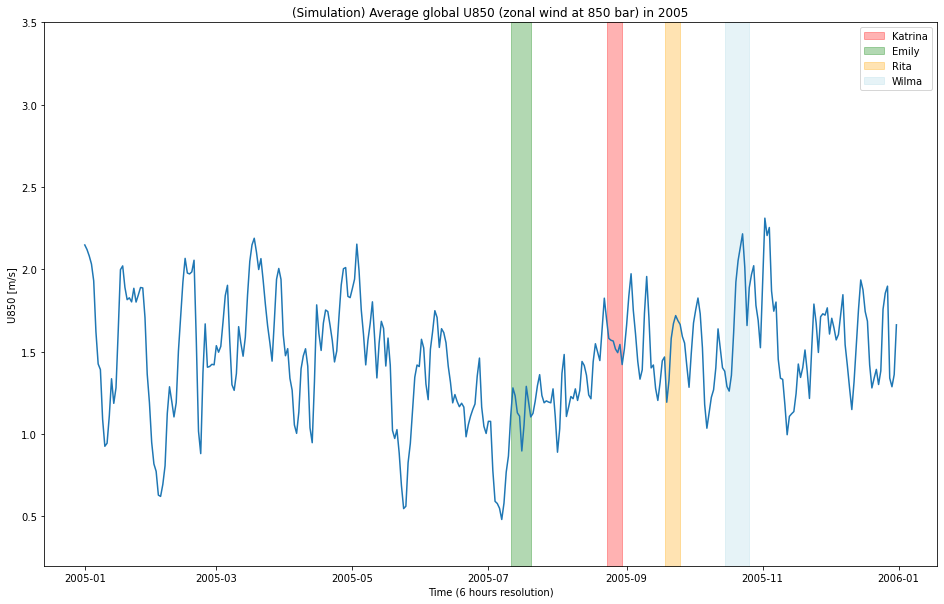

In [88]:
plt.figure(figsize = (16,10))
plt.plot(fake_dates, (np.mean(fake_data, axis = (1,2))))
plt.fill_between(x = katrina_dates, y1 = 3.5, y2 = 0, color = 'red', alpha = 0.3, label = 'Katrina')
plt.fill_between(x = emily_dates, y1 = 3.5, y2 = 0, color = 'green', alpha = 0.3, label = 'Emily')
plt.fill_between(x = rita_dates, y1 = 3.5, y2 = 0, color = 'orange', alpha = 0.3, label = 'Rita')
plt.fill_between(x = wilma_dates, y1 = 3.5, y2 = 0, color = 'lightblue', alpha = 0.3, label = 'Wilma')
plt.ylim(0.2, 3.5)
plt.title("(Simulation) Average global U850 (zonal wind at 850 bar) in 2005")
plt.xlabel("Time (6 hours resolution)")
plt.ylabel("U850 [m/s]")
plt.legend()
plt.show()

In this case, with the simulations, there appears to be no interesting pattern.

# Multi-data visualizations

Given the separate results above confrontations shall be performed. In particular, we are interested in seeing how over the year the two time series, i.e. the real data and the simulation, differ. A second confrontation shall on the plot of the yearly-average, to see in which positions the model tends to underperform: for this case scenario, the use of *re-gridding* is necessary.

### Temporal-Aggregation

We shall evaluate the difference between the yearly averages for 2005 between the real data and the model-generated one.

In [17]:
# Create the Xarray Datasets
# which allow to re-grid
real_mean = xr.Dataset({
    'images': (('lat', 'lon'), np.mean(real_data_U850, axis=0)[()]),
    "lat":
    real_data['latitude'][()],
    "lon":
    real_data['longitude'][()]
})

fake_mean = xr.Dataset({
    'images': (('lat', 'lon'), np.mean(fake_data, axis=0)[()]),
    "lat":
    lat_model,
    "lon":
    lon_model
})

In [83]:
fake_meani = fake_mean.interp(lat=real_mean.lat, lon=real_mean.lon, method='linear')

In [84]:
diff_U850 = real_mean - fake_meani

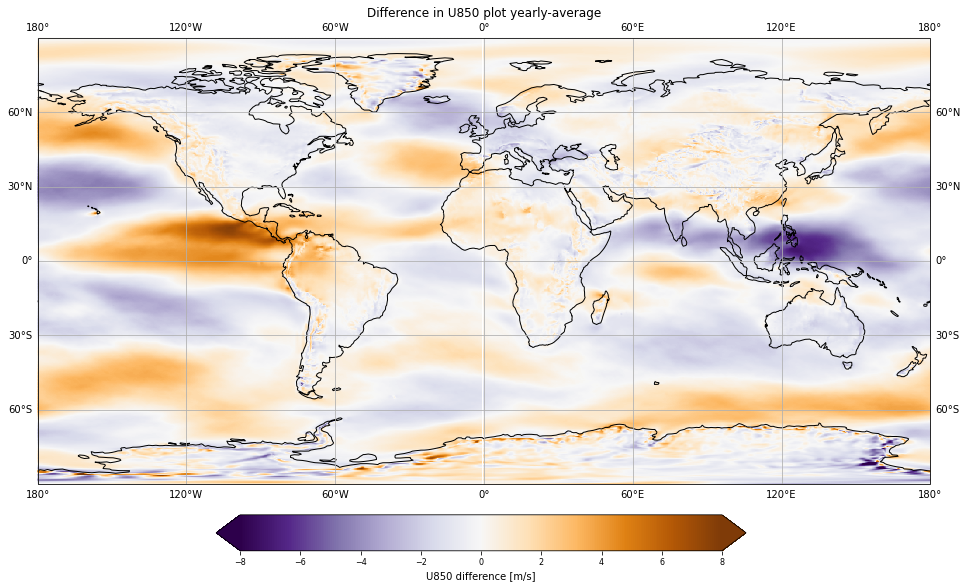

In [85]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(16, 10))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("Difference in U850 plot yearly-average")
ax.set_global()
mm = ax.pcolormesh(real_data['longitude'][()],
                   real_data['latitude'][()],
                   diff_U850.images,
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.PuOr_r,
                   vmin=-8,
                   vmax=8)

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850 difference [m/s]')
cbar.ax.tick_params(labelsize=8)
plt.savefig("./images/average_diff.png", dpi=300)
plt.show()
plt.close()

From this plot it can be deduced that the model sistematically fails two main areas of the globe: around the isle of Burma, in the Celebes Sea, and on the Pacific coast of Mexico. Some other eareas are slightly miss-represented, but nonetheless the variations in the wind tend to be on average small.

### Space Aggregation

The other confrontation is here shown: first a plot with both time series shall be presented, in order to distinguish similarities either in shape or form; and then a plot of the differences is given.

A problem here arises, unfortunately: while the real data has a timestep of 6 hours, the simulated one is just daily. In order to allow a confrontation, averages over 4 measurements for the real data must be performed. 

**NB**: the real data does not have the last day of the year.

In [66]:
real_data_reshaped = np.mean(real_data_U850.reshape(364,4,768,1152), axis =1)

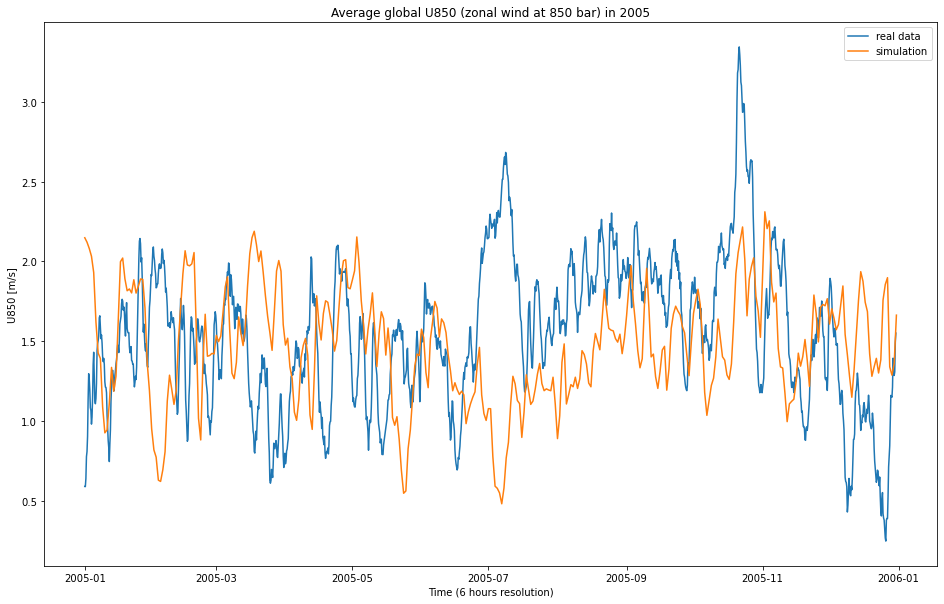

In [75]:
plt.figure(figsize = (16,10))
# plt.plot(fake_dates[:-1], np.mean(real_data_reshaped, axis = (1,2)), label = 'real data')
plt.plot(real_time, np.mean(real_data_U850, axis = (1,2)), label = 'real data')
plt.plot(fake_dates, np.mean(fake_data, axis = (1,2)), label = 'simulation')
plt.title("Average global U850 (zonal wind at 850 bar) in 2005")
plt.xlabel("Time (6 hours resolution)")
plt.ylabel("U850 [m/s]")
plt.legend()
plt.savefig("./images/time_series_together.pdf")
plt.show()

From this first plot it can be inferred that the model fails to simulate accurately the July spike. The August-September trend is somewhat taken. The difference plot might highlight better the discrepancies.

In [87]:
time_diff = np.mean(real_data_reshaped, axis = (1,2)) - np.mean(fake_data, axis = (1,2))[:-1]

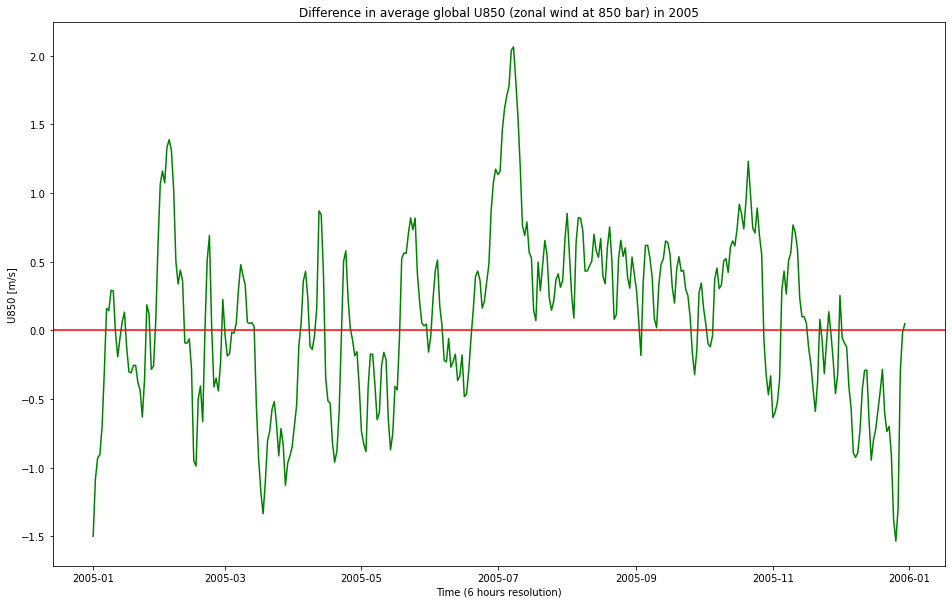

In [88]:
plt.figure(figsize = (16,10))
# plt.plot(fake_dates[:-1], np.mean(real_data_reshaped, axis = (1,2)), label = 'real data')
plt.plot(fake_dates[:-1], time_diff, color = 'green')
plt.title("Difference in average global U850 (zonal wind at 850 bar) in 2005")
plt.xlabel("Time (6 hours resolution)")
plt.ylabel("U850 [m/s]")
plt.axhline(0, color = 'red')
plt.savefig("./images/time_series_diff.pdf")
plt.show()

The plot difference highlight a similar story to the previous one: a large difficulty in dealing with the July peak. The other parts of the year are somewhat described, but not too accurately. 

The Augmented Dickey-Fuller test is performed: this test tries to see if the time series is stationary or not. That is, if its mean is 0 and its variance is constant in time.

In [91]:
print("Augmneted Dickey-Fuller test.\np-value: %.4f" %(adfuller(time_diff)[1]))

Augmneted Dickey-Fuller test.
p-valye: 0.0001


Since the test shows statistical significance, it means that the null hypothesis (non-stationarity) can be rejected: the time series is most likely stationary.
This means that no systematic errors are present in the simulated model, and that differences are most likely statistical.